In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix
#torch for tensor manipulation, and gpu functionality
#torch.nn for neural network building
#optim has optimization algorithms like Adam
#torch.utils.data dataloader for batching and shuffling dataset, subset to create set for training
#confusion matrix for performance metric


import torchvision
import torchvision.transforms as transforms
#torchvision for loading and preprocessing dataset
#torchvision transforms to preprocess and convert images for neural networks

import matplotlib.pyplot as plt
import numpy as np
import time
#matplotlib to visualize data and training results
#numpy for basic matrix manipulation
#time to measure training time

import time 
#measure epoch time



In [77]:
transform = transforms.ToTensor()
#scales pixels and converts images to tensors

In [78]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#Load CIFAR-10 dataset and apply transform to each image



In [79]:
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)
#creates iterable with shuffled batches of 128

In [80]:
#find the mean and std of training dataset to normalize it after
mean = torch.zeros(3)
std = torch.zeros(3)
total_pixels = 0

for images, _ in train_dataloader:
    b,c,h,w = images.shape
    pixels = b*h*w
    total_pixels += pixels
#find total pixels by getting the dimensions of data
    
    mean += images.sum(dim=[0, 2, 3])
    std += (images**2).sum(dim=[0, 2, 3])
#find the sum of pixel value across all color chanels (R,G,B) and sum^2 (to find mean and std deviation after) 

mean /= total_pixels
std = torch.sqrt(std / total_pixels - mean ** 2)
#calculate mean and std deviation of each color channel in dataset
print(mean, std, total_pixels)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616]) 51200000


In [81]:
transform = transforms.Compose([
    transforms.ToTensor(),               
    transforms.Normalize(mean, std)  #updated transform fcn which normalizes too now
])

train_transform = transforms.Compose([
    #data augmentation
    transforms.RandomHorizontalFlip(),      #randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),   #adds 4 pixels of 0 (padding) then randomly crop back to 32x32
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #color changes
    
    transforms.ToTensor(),               
    transforms.Normalize(mean, std)  #updated transform fcn which normalizes too now
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
#Load dataset again and apply transform including normalization to each image. Train set also includes data augmentation
validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
total_indices = torch.randperm(len(train_dataset)).tolist()
train_subset = Subset(train_dataset, total_indices[:40000])
validation_subset = Subset(validation_dataset, total_indices[40000:])

#training data set - 40000 images with random indices for 

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(validation_subset, batch_size=128, shuffle=False)

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, padding=1) #convolution 1
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1) #convolution 2
        self.bn2 = nn.BatchNorm2d(out_channels)
        

        self.downsample = None #For skip connection step  
        if stride != 1 or in_channels != out_channels: #checks if input and output will match dimensions, and if not to match them using downsample
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride), 
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x): #forward prop in a single resnet block
        identity = x
        out = self.relu(self.bn1(self.conv1(x))) #usual forward
        out = self.bn2(self.conv2(out)) #relu applied after skip (shows better performance as it accounts for negative values)
        
        # Adjust skip if necessary
        if self.downsample:
            identity = self.downsample(x)
            
        out += identity  # skip step, input added to output 
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_channels = 16 #tracks input channels, starts at 16
        
        #initial layer
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1) #input 3(RGB channels), output channels of 32(32 features), 3x3 kernel, padding to keep edge data
        self.bn1 = nn.BatchNorm2d(16) #batch norm, reduces overfit and helps converge
        self.relu = nn.ReLU()
        
        #residual layers using resblock class
        self.layer1 = self._make_layer(block, 16, layers[0]) #block - resnet class defined above, layers - resblocks per layer
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2) #stride of 2 to simplify outputs and prevent overfit
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        
        #fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) #pooling to get a vector which fully connected layer expects
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1): #to help with dimension changes due to stride
        layers = []

        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels #new input size becomes old output size

        for _ in range(1, blocks): #only first blocks apply stride, rest of blocks stay same
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x))) #input layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        

In [83]:
#Using ResNet-18 type NN, lightweight and good for small image dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResNetBlock, layers=[2, 2, 2], num_classes=10)

# send the model to GPU
model = model.to(device)

In [84]:
criterion = nn.CrossEntropyLoss() #basic loss generally used for classification
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay = 0.01) # adaptive moment optimizer with L2 regularization (decoupled unlike Adam)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) #Learning rate scheduler - decreases it by half every 10 epoch

num_epochs = 150 #training loops going through entire train set
patience = 15  # stop if val loss doesn't improve for x epochs
best_val_loss = float('inf') #make sure first epoch loss is less, so start at inf
counter = 0  #counter to compare to patience

In [85]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) #send inputs to GPU

        #forward step to find output guesses
        outputs = model(images) #goes through CNN process to find final logits
        loss = criterion(outputs, labels) #calculates the loss

        #backprop to optimize weights
        optimizer.zero_grad() #resets gradient every batch, else would keep adding
        loss.backward() #backward prop to find dL/dw
        optimizer.step() #changes weights accordingly

        train_loss += loss.item() * images.size(0)  #sum over batch

    train_loss /= len(train_loader.dataset)  #average per epoch
    train_losses.append(train_loss) #keep in array for graphing later


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)  #average per epoch
    val_losses.append(val_loss) #for graph

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')  #saves the best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    end = time.time()
    print(f" --- Epoch {epoch+1} completed in {end - start:.2f} seconds")
scheduler.step()

Epoch 1, Train Loss: 1.6268, Val Loss: 1.4847
 --- Epoch 1 completed in 24.14 seconds
Epoch 2, Train Loss: 1.2204, Val Loss: 1.1569
 --- Epoch 2 completed in 24.23 seconds
Epoch 3, Train Loss: 1.0422, Val Loss: 1.0358
 --- Epoch 3 completed in 24.88 seconds
Epoch 4, Train Loss: 0.9282, Val Loss: 0.9610
 --- Epoch 4 completed in 25.45 seconds
Epoch 5, Train Loss: 0.8515, Val Loss: 0.8467
 --- Epoch 5 completed in 24.38 seconds
Epoch 6, Train Loss: 0.7874, Val Loss: 0.8310
 --- Epoch 6 completed in 25.56 seconds
Epoch 7, Train Loss: 0.7334, Val Loss: 0.8184
 --- Epoch 7 completed in 24.82 seconds
Epoch 8, Train Loss: 0.6883, Val Loss: 0.7249
 --- Epoch 8 completed in 25.17 seconds
Epoch 9, Train Loss: 0.6492, Val Loss: 0.8200
 --- Epoch 9 completed in 24.71 seconds
Epoch 10, Train Loss: 0.6199, Val Loss: 0.7961
 --- Epoch 10 completed in 23.83 seconds
Epoch 11, Train Loss: 0.5925, Val Loss: 0.6806
 --- Epoch 11 completed in 24.68 seconds
Epoch 12, Train Loss: 0.5732, Val Loss: 0.6513
 --

In [90]:
test_dataset = torchvision.datasets.CIFAR10( root='./data', train=False,transform=transform) # Load Test Set now, final version
test_loader = DataLoader( test_dataset, batch_size=128, shuffle=False )

classes = [ "PLANE", "CAR", "BIRD", "CAT", "DEER", "DOG", "FROG", "HORSE", "SHIP", "TRUCK" ]
num_classes = 10
test_correct = 0
test_total = 0

all_predictions = []
all_labels = []

model.load_state_dict(torch.load('best_model.pt'))
model.eval()

#Train accuracy
train_correct = 0
train_total = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

train_acc = 100 * train_correct / train_total

#Test accuracy
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_predictions.append(predicted.cpu()) #append each prediction to all_predictions tensor
        all_labels.append(labels.cpu()) #same for labels (true answers)

test_acc = 100 * test_correct / test_total

print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")


all_predictions_flat = torch.cat(all_predictions).numpy() #returns a flattened numpy array of all predictions
all_labels_flat = torch.cat(all_labels).numpy() #does same for all labels 


cm = confusion_matrix(all_labels_flat, all_predictions_flat)
print("Confusion Matrix:")
print(cm)

per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"class {classes[i]} Accuracy: {acc*100:.2f}%")

Train Accuracy: 92.49%
Test Accuracy: 87.06%
Confusion Matrix:
[[903   6  34  10   8   1   4   7  12  15]
 [ 12 923   2   3   1   5   3   1   2  48]
 [ 30   0 823  40  49  26  16  11   2   3]
 [ 21   0  38 760  46  93  16  17   1   8]
 [  8   1  30  23 892  16  10  20   0   0]
 [  6   0  17 111  31 810   6  19   0   0]
 [  4   0  31  53  33   8 862   6   2   1]
 [  8   1   8  30  20  27   1 903   0   2]
 [ 52   6   1   8   3   3   5   3 901  18]
 [ 15  29   8   3   3   1   1   3   8 929]]
class PLANE Accuracy: 90.30%
class CAR Accuracy: 92.30%
class BIRD Accuracy: 82.30%
class CAT Accuracy: 76.00%
class DEER Accuracy: 89.20%
class DOG Accuracy: 81.00%
class FROG Accuracy: 86.20%
class HORSE Accuracy: 90.30%
class SHIP Accuracy: 90.10%
class TRUCK Accuracy: 92.90%


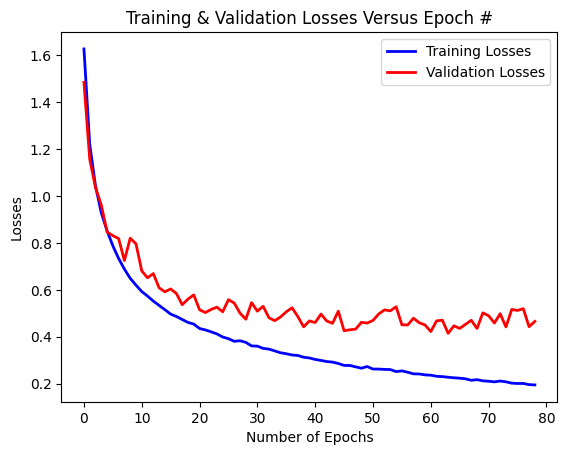

In [91]:
#plot losses vs epoch
x = np.arange(len(train_losses))
plt.plot(x, train_losses, label='Training Losses', color='blue', linewidth=2)
plt.plot(x, val_losses, label='Validation Losses', color='red', linewidth=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Losses')
plt.title('Training & Validation Losses Versus Epoch #')
plt.legend()
plt.show()

